# 天池零基础入门推荐系统 - 新闻推荐
## 周京菁 吴亚凝

## 数据读取

In [2]:
import time, math, os
from tqdm import tqdm            # Tqdm 是一个快速，可扩展的Python进度条
import gc    # 垃圾回收
import pickle   #  用于序列化和反序列化Python对象结构的二进制协议
import random
from datetime import datetime
from operator import itemgetter    # Python内部操作符的函数
import numpy as np
import pandas as pd
import warnings
from collections import defaultdict    # collections----容器数据类型
import collections
warnings.filterwarnings('ignore') 

In [4]:
# 读取采样或全量数据
# debug模式：从训练集中划出一部分数据来调试代码
data_path = r"F:\机器学习"
save_path = r"F:\机器学习"
def get_all_click_sample(data_path, sample_nums=10000):
    """
        训练集中采样一部分数据调试
        data_path: 原数据的存储路径
        sample_nums: 采样数目（这里由于机器的内存限制，可以采样用户做）
    """
    all_click = pd.read_csv(data_path + r'\train_click_log.csv')
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False) 
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

# 读取点击数据
def get_all_click_df(data_path, offline=True):
    if offline:
        all_click = pd.read_csv(data_path + r'\train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + r'\train_click_log.csv')
        tst_click = pd.read_csv(data_path + r'\testA_click_log.csv')

        all_click = trn_click.append(tst_click)
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click
# 全量训练集
all_click_df = get_all_click_df(data_path, offline=False)

In [5]:
all_click_df.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5


In [6]:
all_click_df.shape

(1630633, 9)

## 获取 用户 - 文章 - 点击时间字典

In [7]:
# 获取 用户 - 文章 - 点击时间字典
# 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
def get_user_item_time(click_df):
    
    click_df = click_df.sort_values('click_timestamp')   # 按照时间排序
    
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    user_item_time_df = click_df.groupby('user_id')['click_article_id', 'click_timestamp'].apply(lambda x: make_item_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict

In [8]:
get_user_item_time(all_click_df)

{0: [(30760, 1508211672520), (157507, 1508211702520)],
 1: [(289197, 1508211316889), (63746, 1508211346889)],
 2: [(36162, 1508211438695), (168401, 1508211468695)],
 3: [(50644, 1508211359672), (36162, 1508211389672)],
 4: [(42567, 1508211625466), (39894, 1508211655466)],
 5: [(211442, 1508211243884), (234481, 1508211273884)],
 6: [(62464, 1508212140776), (10023, 1508212170776)],
 7: [(50644, 1508211313878), (211442, 1508211343878)],
 8: [(70986, 1508211172391), (50644, 1508211202391)],
 9: [(70986, 1508211213614), (211442, 1508211245547), (211455, 1508211275547)],
 10: [(50644, 1508211631144), (159195, 1508211661144)],
 11: [(50644, 1508211074535), (234481, 1508211104535)],
 12: [(211442, 1508211061254), (211455, 1508211091254)],
 13: [(36162, 1508211428226), (277107, 1508211458226)],
 14: [(70986, 1508210959082), (36162, 1508210989082)],
 15: [(277107, 1508210921971),
  (342473, 1508211137084),
  (206415, 1508211167084)],
 16: [(50644, 1508210982166), (211442, 1508211012166)],
 17: [

## 获取点击最多的topk个文章

In [9]:
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
    return topk_click

## 对时间戳进行归一化

In [10]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
# 对时间戳进行归一化,用于在关联规则的时候计算权重
all_click_df['click_timestamp'] = all_click_df[['click_timestamp']].apply(max_min_scaler)

## 物品相似度计算

In [17]:
# itemcf的物品相似度计算
def itemcf_sim(df):
    user_item_time_dict = get_user_item_time(df)
    # 计算物品相似度
    i2i_sim = {}
    item_cnt = defaultdict(int)    # 当字典的key不存在返回一个int，0
    for user, item_time_list in tqdm(user_item_time_dict.items()):   # 设置进度条
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for loc1,(i, i_click_time) in enumerate(item_time_list):
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for loc2,(j, j_click_time) in enumerate(item_time_list):
                if(i == j):
                    continue
                # 考虑文章的正向顺序点击和反向顺序点击    
                loc_alpha = 1.0 if loc2 > loc1 else 0.7
                # 位置信息权重，其中的参数可以调节
                loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))
                # 点击时间权重，其中的参数可以调节
                click_time_weight = np.exp(0.7 ** np.abs(i_click_time - j_click_time))
                # 两篇文章创建时间的权重，其中的参数可以调节
                created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))               
                i2i_sim[i].setdefault(j, 0)
                # 考虑多种因素的权重计算最终的文章之间的相似度
                i2i_sim[i][j] += loc_weight * click_time_weight * created_time_weight / math.log(len(item_time_list) + 1)
                                
    i2i_sim_ = i2i_sim.copy()
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i]*item_cnt[j])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_, open(save_path + 'itemcf_i2i_sim.pkl', 'wb'))    
    return i2i_sim_

i2i_sim = itemcf_sim(all_click_df)

100%|████████████████████████████████████████████████████████████████████████| 250000/250000 [02:28<00:00, 1685.74it/s]


In [64]:
# itemcf 的文章推荐
# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全        
        return: 召回的文章列表 {item1:score1, item2: score2...}
        注意: 基于物品的协同过滤(详细请参考上一期推荐系统基础的组队学习)， 在多路召回部分会加上关联规则的召回策略
    """
    
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    
    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
        #对user看过的文章i的相关文章j排序
            if j in user_hist_items_:#不要推荐看过的文章
                continue
            # 文章创建时间差权重
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
            # 相似文章和历史点击文章序列中历史文章所在的位置权重
            loc_weight = (0.9 ** (len(user_hist_items) - loc))
            
            content_weight = 1.0
            #if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                #content_weight += emb_i2i_sim[i][j]
            #if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                #content_weight += emb_i2i_sim[j][i]
                
            item_rank.setdefault(j, 0)
            item_rank[j] += created_time_weight * loc_weight * content_weight * wij
    
    # 不足10个，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items(): # 填充的item应该不在原来的列表中
                continue
            item_rank[item] = - i - 100 # 随便给个负数就行
            if len(item_rank) == recall_item_num:
                break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
        
    return item_rank

In [53]:
# 给每个用户根据物品的协同过滤推荐文章
# 定义
user_recall_items_dict = collections.defaultdict(dict)

# 获取 用户 - 文章 - 点击时间的字典
user_item_time_dict = get_user_item_time(all_click_df)

# 去取文章相似度
i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))
#i2i_sim = pickle.load(open('F:/机器学习/recall_itemcf.pkl', 'rb'))

# 相似文章的数量
sim_item_topk = 10

# 召回文章数量
recall_item_num = 10

# 用户热度补全
item_topk_click = get_item_topk_click(all_click_df, k=50)



In [65]:
for user in tqdm(all_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, 
                                                        sim_item_topk, recall_item_num, item_topk_click)

100%|████████████████████████████████████████████████████████████████████████| 250000/250000 [1:10:13<00:00, 59.33it/s]


In [66]:
user_recall_items_dict[1]

[(63800, 0.13761942008072653),
 (30408, 0.1053138360297925),
 (49405, 0.08341203099802029),
 (63760, 0.07664334802394646),
 (323677, 0.06963554667361523),
 (160807, 0.06493573856700662),
 (63795, 0.06447847066379299),
 (63672, 0.05798404551382593),
 (48401, 0.057599314477296465),
 (63783, 0.05674144787501027)]

In [67]:
# 召回字典转换成df
# 将字典的形式转换成df
user_item_score_list = []

for user, items in tqdm(user_recall_items_dict.items()):
    for item, score in items:
        user_item_score_list.append([user, item, score])

recall_df = pd.DataFrame(user_item_score_list, columns=['user_id', 'click_article_id', 'pred_score'])

100%|███████████████████████████████████████████████████████████████████████| 250000/250000 [00:04<00:00, 52059.02it/s]


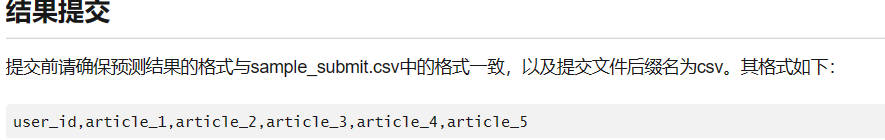

## 生成提交文件

In [68]:
# 生成提交文件
def submit(recall_df, topk=5, model_name=None):
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 判断是不是每个用户都有5篇文章及以上
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk
    
    del recall_df['pred_score']
    submit = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()
    
    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2', 
                                                  3: 'article_3', 4: 'article_4', 5: 'article_5'})
    
    save_name = save_path + model_name + '_' + datetime.today().strftime('%m-%d') + '.csv'
    return submit.to_csv(save_name, index=False, header=True)
     

# 获取测试集
tst_click = pd.read_csv(data_path + r'\testA_click_log.csv')
tst_users = tst_click['user_id'].unique()

# 从所有的召回数据中将测试集中的用户选出来
tst_recall = recall_df[recall_df['user_id'].isin(tst_users)]


In [69]:
# 生成提交文件
submit(tst_recall, topk=5, model_name=r'\itemcf_baseline')

In [51]:
i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))

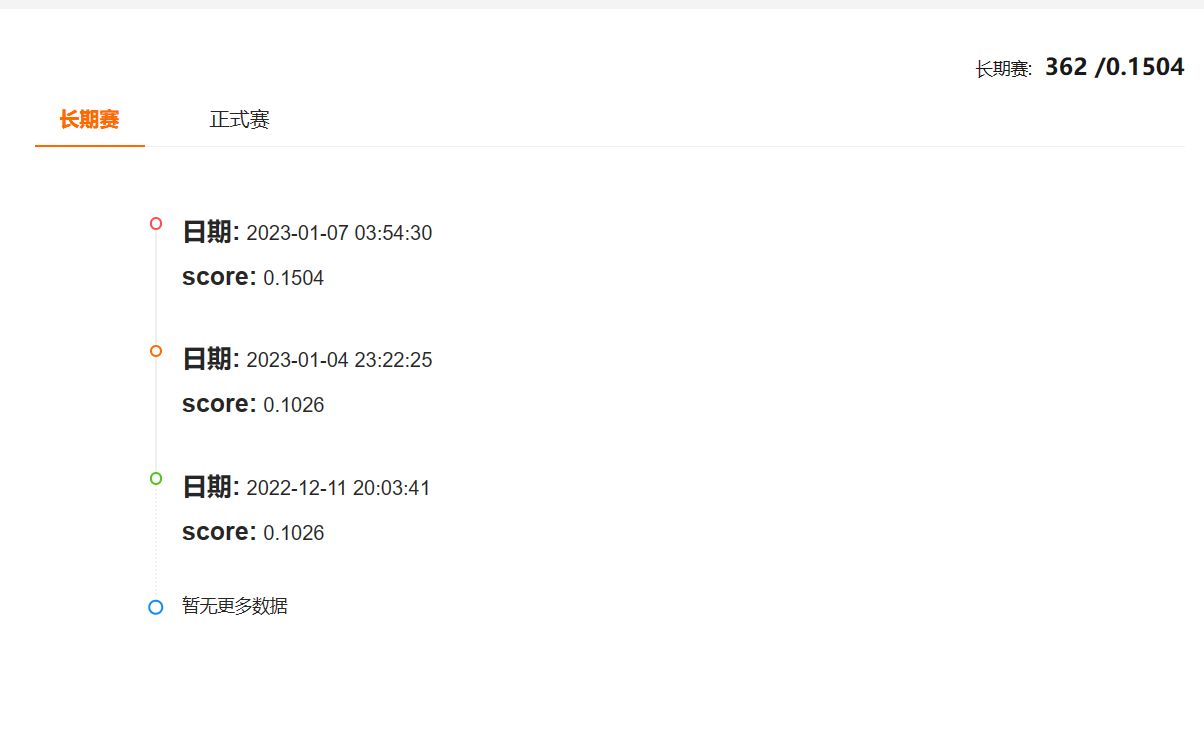